<a href="https://colab.research.google.com/github/Olhaau/fl-official-statistics-addon/blob/main/_dev/99d_insurance_federated_wrapup_fix.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Federated Insurance

Open

- [ ] ~~RSquared for FL, but it is only available in tf-nightly and the installation broke the env~~
- [ ] 5 features (no region) centralized
- [ ] document all input and outputs in FLutils
- [ ] test colab

## Prerequisites
---

### Libraries
---

In [5]:
# Setup colab if needed

try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False

print("COLAB? {}".format(IN_COLAB))

if IN_COLAB:
    import os
    
    # rm repo from gdrive
    if os.path.exists("fl-official-statistics-addon"):
      %rm -r fl-official-statistics-addon

    # clone
    !git clone https://github.com/Olhaau/fl-official-statistics-addon
    %cd fl-official-statistics-addon

    # pull (the currenct version of the repo)
    !git pull

    !pip install -q tensorflow-federated==0.56.0
    # or possibly !pip install -r requirements.txt

    os.chdir("_dev")



COLAB? False


In [6]:
!python --version
# tested 3.9.* or 3.10.*.

/bin/bash: /home/olihauke/.asdf/installs/python/miniconda3-latest/envs/env-tff/lib/libtinfo.so.6: no version information available (required by /bin/bash)
Python 3.9.16


In [7]:
# show library versions
# =========================
!pip list | grep tensorflow
# tensorflow                    2.12.0
# tensorflow-federated          0.56.0

/bin/bash: /home/olihauke/.asdf/installs/python/miniconda3-latest/envs/env-tff/lib/libtinfo.so.6: no version information available (required by /bin/bash)
tensorflow                    2.12.0
tensorflow-addons             0.20.0
tensorflow-compression        2.12.0
tensorflow-datasets           4.9.2
tensorflow-estimator          2.12.0
tensorflow-federated          0.56.0
tensorflow-io-gcs-filesystem  0.32.0
tensorflow-metadata           1.13.1
tensorflow-model-optimization 0.7.3
tensorflow-privacy            0.8.8
tensorflow-probability        0.15.0


In [8]:
# suppress tf debug logging
# =========================
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

#0 = all messages are logged (default behavior)
#1 = INFO messages are not printed
#2 = INFO and WARNING messages are not printed
#3 = INFO, WARNING, and ERROR messages are not printed

# S. https://stackoverflow.com/questions/35911252/disable-tensorflow-debugging-information

In [9]:
# imports
# =======
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tqdm
import tensorflow_federated as tff
import tensorflow as tf
from sklearn.model_selection import RepeatedKFold, train_test_split, RepeatedStratifiedKFold

from keras.callbacks import CSVLogger

from FLutils import load_df, create_keras_model, model_fn, prep_fed_train, prep_fed_test, train_model,train_fed
#import FLutils

# logging path
out_path = '../output/experiments' 

### Data preperation
---

In [10]:
# ingest data
# ===========

df_paths = [
    '../output/data/insurance-clean.csv',
    "https://raw.githubusercontent.com/Olhaau/fl-official-statistics-addon/main/output/data/insurance-clean.csv"
]

df = load_df(df_paths)
df.head(3)

loaded data from ../output/data/insurance-clean.csv


,age,sex,bmi,children,smoker,region,charges,region0,region1,region2,region3
0,0.021739,0.0,0.321227,0.0,1.0,southwest,16884.9240,0.0,0.0,0.0,1.0
1,0.000000,1.0,0.479150,0.2,0.0,southeast,1725.5523,0.0,0.0,1.0,0.0
2,0.217391,1.0,0.458434,0.6,0.0,southeast,4449.4620,0.0,0.0,1.0,0.0


In [11]:
# select features, target (first column) and clients
# ==================================================

# features for centralized learning
features = ['age', 'sex', 'bmi', 'children', 'smoker'
            , 'region0', 'region1', 'region2', 'region3']

target = 'charges'

# features for federated learning
features_fed = features[:5]

# clients for data splits
clients = df.region.unique()

# show target + features in the data
df.loc[:, [target] + features ].head(3)

,charges,age,sex,bmi,children,smoker,region0,region1,region2,region3
0,16884.9240,0.021739,0.0,0.321227,0.0,1.0,0.0,0.0,0.0,1.0
1,1725.5523,0.000000,1.0,0.479150,0.2,0.0,0.0,0.0,1.0,0.0
2,4449.4620,0.217391,1.0,0.458434,0.6,0.0,0.0,0.0,1.0,0.0


### Budget
---

#### Evaluation

In [12]:
# create evaluation splits
# ========================

nreps, nfolds = 5, 5
evaluation = RepeatedStratifiedKFold(n_splits = nfolds, n_repeats = nreps, random_state = 42)


#### Training

In [13]:
n_epochs     = 100
n_epochs_fed =  50
n_rounds_fed =  50  

### Model
---

In [14]:
# define model architecture
# =========================

def keras_blueprint(compile = False, nfeatures = len(features_fed)):
    if nfeatures == None: nfeatures = len(features)
    
    return create_keras_model(
        nfeatures = nfeatures, 
        units = [40, 40, 20], 
        activations = ['relu'] * 3, 
        compile = compile)

# Note 1: we do not compile the model yet. The loss, metrics, and optimizers are introduced later.
# S. https://www.tensorflow.org/federated/tutorials/federated_learning_for_image_classification#creating_a_model_with_keras
# Note 2: this function has to generate a new instance of a keras_model 
#         to be useable for generating a federated learning process
# Note 3: loss = mae -> overfitting?

# show the model specifics
keras_blueprint().summary()
keras_blueprint(compile=True).get_compile_config()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 40)                240       
                                                                 
 dense_1 (Dense)             (None, 40)                1640      
                                                                 
 dense_2 (Dense)             (None, 20)                820       
                                                                 
 dense_3 (Dense)             (None, 1)                 21        
                                                                 
Total params: 2,721
Trainable params: 2,721
Non-trainable params: 0
_________________________________________________________________


{'optimizer': {'module': 'keras.optimizers.legacy',
  'class_name': 'Adam',
  'config': {'name': 'Adam',
   'learning_rate': 0.05,
   'decay': 0.0,
   'beta_1': 0.9,
   'beta_2': 0.999,
   'epsilon': 1e-07,
   'amsgrad': False},
  'registered_name': None},
 'loss': 'mean_squared_error',
 'metrics': ['mae',
  'mean_squared_error',
  {'module': 'sklearn.metrics._regression',
   'class_name': 'function',
   'config': 'r2_score',
   'registered_name': 'r2_score'}],
 'loss_weights': None,
 'weighted_metrics': None,
 'run_eagerly': True,
 'steps_per_execution': None,
 'jit_compile': None}

### Federated Process
---

The federated training process is constructed from a keras model in the function `train_fed`. See `help(train_fed)`.

The generated default process is:

In [51]:
tff_process = tff.learning.algorithms.build_weighted_fed_avg(
	model_fn(
		keras_creator = keras_blueprint,
		loss = tf.losses.MeanSquaredError()
	),
	client_optimizer_fn = lambda: tf.optimizers.Adam(learning_rate = .05),
	server_optimizer_fn = lambda: tf.optimizers.Adam(learning_rate = .05)
 )

print(tff_process.initialize.type_signature.formatted_representation())


( -> <
  global_model_weights=<
    trainable=<
      float32[5,40],
      float32[40],
      float32[40,40],
      float32[40],
      float32[40,20],
      float32[20],
      float32[20,1],
      float32[1]
    >,
    non_trainable=<>
  >,
  distributor=<>,
  client_work=<>,
  aggregator=<
    value_sum_process=<>,
    weight_sum_process=<>
  >,
  finalizer=<
    int64,
    float32[5,40],
    float32[5,40],
    float32[40],
    float32[40],
    float32[40,40],
    float32[40,40],
    float32[40],
    float32[40],
    float32[40,20],
    float32[40,20],
    float32[20],
    float32[20],
    float32[20,1],
    float32[20,1],
    float32[1],
    float32[1]
  >
>@SERVER)


## Federated Learning
---

In [15]:
experiment_name = '06_federated_fix'

experiment_path = out_path + "/" + experiment_name + "/"
if not os.path.exists(experiment_path + 'logs'): os.makedirs(experiment_path + 'logs')
if not os.path.exists(experiment_path + 'models'): os.makedirs(experiment_path + 'models')
if not os.path.exists(experiment_path + 'results'): os.makedirs(experiment_path + 'results')

### FED Train 
---

In [16]:
# compute train
# =============

results_fed = []

eval_ind = 0#nfolds*7#0
for train, test in tqdm.tqdm(list(evaluation.split(df, df.region))[:]):

    # Logging
    rep  = int(eval_ind / nfolds)
    fold = int(eval_ind % nfolds)
    eval_ind += 1
    id = "r" + str(rep) + "f" + str(fold)
    #print('======= rep %s - fold %s  =======' % (rep, fold))


    # distribute train (and eval) data over the client and prep tensors.
    train_data_fed = []
    eval_data_fed  = []   
    for client in clients:
        outer_train_data_client = df[(df.index.isin(train)) & (df.region == client)]
        train_data_client, eval_data_client = train_test_split(outer_train_data_client, test_size = 0.1, random_state = 42)
        
        train_data_fed.append(
            prep_fed_train(train_data_client[features_fed], train_data_client[target])) 
        eval_data_fed.append(
            prep_fed_test(eval_data_client[features_fed], eval_data_client[target]))
        
    # train
    #with tf.device('/device:gpu:0'): # possibly needed for colab
    result =  train_fed(
        model = model_fn(
            keras_creator = keras_blueprint,
            loss = tf.losses.MeanSquaredError()
        ),
        train_data = train_data_fed,
        eval_data  = eval_data_fed,
        NUM_ROUNDS = n_rounds_fed,
        NUM_EPOCHS = n_epochs_fed,
        client_optimizer = lambda: tf.optimizers.Adam(learning_rate = .05),
        server_optimizer = lambda: tf.optimizers.Adam(learning_rate = .05),
        BATCH_SIZE = 128,
        SHUFFLE_BUFFER = 20,
        PREFETCH_BUFFER = 5,
        SEED = 42,
        verbose = False
    )
    
    # save history
    pd.DataFrame(result['history']).to_csv(experiment_path + "logs/" + id + '_log.csv', sep = ";")

    # save model
    model = keras_blueprint()
    model_weights = result['process'].get_model_weights(result['state'])
    model_weights.assign_weights_to(model)
    model.save_weights(experiment_path + "models/" + id + '_weights.h5')
    
    # Note: load with e.g. 
    #   model = keras_blueprint(compile = True)
    #   model.load_weights(experiment_path + 'models/r0f0_weights.h5')
    #   model.weights

    results_fed.append(result)

100%|██████████| 25/25 [07:03<00:00, 16.94s/it]


In [17]:
# show train result
# =======================
table = pd.DataFrame([res['history'][-1] for res in results_fed])
table.to_csv(experiment_path + "results/performance_train.csv", sep = ";")
table.describe().to_csv(experiment_path + "results/performance_train_overview.csv", sep = ";")
table.describe().round(2)

,mean_absolute_error,mean_squared_error,loss,num_examples,num_batches,val_mean_absolute_error,val_mean_squared_error,val_loss,val_num_examples,val_num_batches
count,25.00,25.0,25.00,25.0,25.00,25.00,25.0,25.0,25.0,25.0
mean,2721.60,21487692.0,21515648.00,48120.0,378.20,3748.18,29640322.0,30112858.0,108.0,4.0
std,104.71,1310277.0,1302227.12,25.0,0.41,383.69,7387289.5,7684861.5,0.0,0.0
min,2487.06,18415500.0,18488122.00,48100.0,378.00,3147.54,18476548.0,18734128.0,108.0,4.0
25%,2676.82,20466472.0,20487854.00,48100.0,378.00,3565.33,24924480.0,25131972.0,108.0,4.0
50%,2725.35,21680022.0,21705348.00,48100.0,378.00,3676.18,28657808.0,29233702.0,108.0,4.0
75%,2793.87,22457248.0,22463340.00,48150.0,378.00,3908.82,32813152.0,33598416.0,108.0,4.0
max,2873.92,23431504.0,23514486.00,48150.0,379.00,4566.28,46247084.0,47951104.0,108.0,4.0


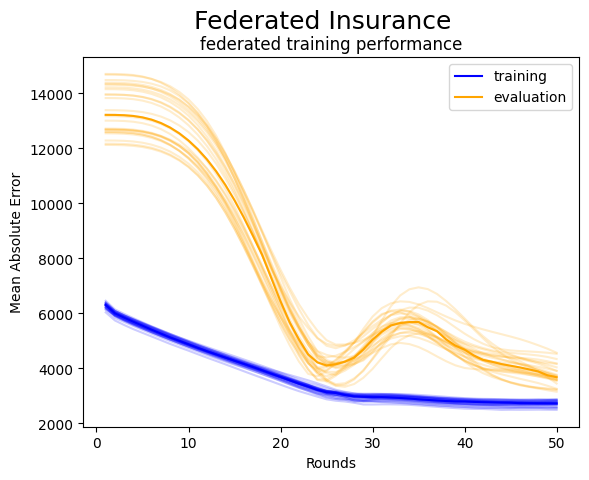

In [18]:
# plot train result (MAE)
# =======================
y = np.array([[hist['mean_absolute_error'] for hist in res['history']] for res in results_fed]).transpose()
yval = np.array([[hist['val_mean_absolute_error'] for hist in res['history']] for res in results_fed]).transpose()


xran = range(1,y.shape[0] + 1)
plt.plot(xran, y, color = 'blue', alpha = .2)
plt.plot(xran, np.quantile(y,.5, axis = 1), label = 'training', color = 'blue')
plt.plot(xran, yval, color = 'orange', alpha = .2)
plt.plot(xran, np.quantile(yval,.5, axis = 1), label = 'evaluation', color = 'orange')
plt.xlabel("Rounds")
plt.ylabel("Mean Absolute Error")
plt.suptitle('Federated Insurance', fontsize=18)
plt.title('federated training performance')
plt.legend()
plt.savefig(experiment_path + 'results/training_performance_mae.png')
plt.show()

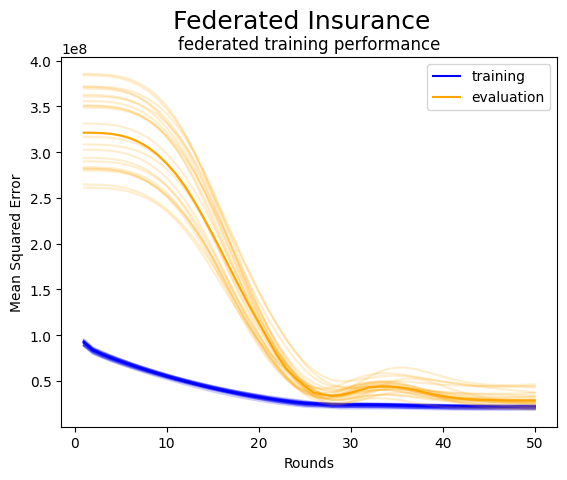

In [19]:
# plot train result (MSE)
# =======================

y = np.array([[hist['mean_squared_error'] for hist in res['history']] for res in results_fed]).transpose()
yval = np.array([[hist['val_mean_squared_error'] for hist in res['history']] for res in results_fed]).transpose()


xran = range(1,y.shape[0] + 1)
plt.plot(xran, y, color = 'blue', alpha = .2)
plt.plot(xran, np.quantile(y,.5, axis = 1), label = 'training', color = 'blue')
plt.plot(xran, yval, color = 'orange', alpha = .2)
plt.plot(xran, np.quantile(yval,.5, axis = 1), label = 'evaluation', color = 'orange')
plt.xlabel("Rounds")
plt.ylabel("Mean Squared Error")
plt.suptitle('Federated Insurance', fontsize=18)
plt.title('federated training performance')
plt.legend()
plt.savefig(experiment_path + 'results/training_performance_mse.png')
plt.show()

### FED Test
---

In [20]:
# calculate test
# ==============
results_fed_test = []

model = keras_blueprint(compile = True)

i = 0
for train, test in tqdm.tqdm(list(evaluation.split(df, df.region))):
    data_test = df.loc[test]
    X_test, y_test = data_test[features_fed], data_test[target]
    
    # calculate test performance
    model_weights = results_fed[i]['process'].get_model_weights(results_fed[i]['state'])
    i += 1
    model_weights.assign_weights_to(model)
    
    perf_test = model.evaluate(X_test, y_test, verbose = 0)
    perf_test = dict(zip(model.metrics_names, perf_test))

    results_fed_test.append(perf_test)


100%|██████████| 25/25 [00:12<00:00,  1.94it/s]


In [32]:
# show test results
# =================
table2 = pd.DataFrame(results_fed_test)
table2 = table2.set_axis(['test_'+ col for col in table2.columns], axis = 1)

table2.to_csv(experiment_path + "results/performance_test.csv", sep = ";")
table2.describe()[1:].to_csv(experiment_path + "results/performance_test_overview.csv", sep = ";")
table_all_fed = pd.concat([table, table2], axis = 1)
table_all_fed.describe()[1:].to_csv(experiment_path + "results/performance_overview.csv", sep = ";")
table_all_fed.to_csv(experiment_path + "results/performance.csv", sep = ";")

table_all_fed.describe()[1:].transpose().round(4)

,mean,std,min,25%,50%,75%,max
loss,2.163669e+07,1.173221e+06,1.807676e+07,2.147984e+07,2.175619e+07,2.220978e+07,2.355602e+07
mae,2.730711e+03,1.457336e+02,2.378653e+03,2.655450e+03,2.713002e+03,2.814412e+03,3.101265e+03
mean_squared_error,2.163669e+07,1.173221e+06,1.807676e+07,2.147984e+07,2.175619e+07,2.220978e+07,2.355602e+07
r2_score,8.466000e-01,9.900000e-03,8.315000e-01,8.422000e-01,8.467000e-01,8.508000e-01,8.722000e-01
val_loss,2.554195e+07,3.123814e+06,1.723868e+07,2.389980e+07,2.605508e+07,2.737339e+07,3.084570e+07
val_mae,3.057359e+03,2.943481e+02,2.453868e+03,2.865973e+03,3.059461e+03,3.208298e+03,3.720817e+03
val_mean_squared_error,2.554195e+07,3.123814e+06,1.723868e+07,2.389980e+07,2.605508e+07,2.737339e+07,3.084570e+07
val_r2_score,8.345000e-01,1.880000e-02,7.925000e-01,8.216000e-01,8.347000e-01,8.472000e-01,8.780000e-01
test_loss,2.682777e+07,3.641359e+06,2.198053e+07,2.344902e+07,2.614844e+07,2.835313e+07,3.624404e+07
test_mae,3.515067e+03,2.491892e+02,3.136757e+03,3.305468e+03,3.579872e+03,3.698145e+03,4.005001e+03


## Centralized DNN
---

### Setup
---

Using 9 Features.

In [22]:
experiment_name = '07_central_fix'

experiment_path = out_path + "/" + experiment_name + "/"
if not os.path.exists(experiment_path + 'logs'): os.makedirs(experiment_path + 'logs')
if not os.path.exists(experiment_path + 'models'): os.makedirs(experiment_path + 'models')
if not os.path.exists(experiment_path + 'results'): os.makedirs(experiment_path + 'results')

### CTR Train
---

In [23]:
# calculate training
# ==================
results_ctr = []

eval_ind = 0
for train, test in tqdm.tqdm(list(evaluation.split(df, df.region))):

    # Logging
    rep  = int(eval_ind / nfolds)
    fold = int(eval_ind % nfolds)
    eval_ind += 1
    id = "r" + str(rep) + "f" + str(fold)
    #print('======= rep %s - fold %s  =======' % (rep, fold))
    
    
    data_train = df.loc[train]
    X_train, y_train = data_train[features], data_train[target]

    model = keras_blueprint(nfeatures = len(features), compile = True)
    
    result = train_model(
        model, X_train, y_train,
        epochs = n_epochs, 
        #output_msr = "r2_score",
        callbacks = [CSVLogger(experiment_path + "logs/" + id + '_log.csv'  , separator =";")],
        seed = 42,
        verbose = False
    )
    model.save_weights(experiment_path + "models/" + id + '_weights.h5')

    results_ctr.append(result)


100%|██████████| 25/25 [15:25<00:00, 37.04s/it]


In [31]:
# show train results
# ==================
table = pd.DataFrame(
    [{key: val[-1] for key, val in hist.history.items()} for hist in results_ctr]
    ).assign(
    #r2_score    = lambda x: x.r2_score * 100,
    #val_r2_score = lambda x: x.val_r2_score * 100
)

table.describe()[1:].to_csv(experiment_path + "results/performance_train_overview.csv", sep = ";")
table.round(2)

,loss,mae,mean_squared_error,r2_score,val_loss,val_mae,val_mean_squared_error,val_r2_score
0,21626550.0,2757.34,21626550.0,0.84,29159864.0,2880.28,29159864.0,0.81
1,19210398.0,2495.15,19210398.0,0.87,20524960.0,2673.47,20524960.0,0.85
2,20410248.0,2650.53,20410248.0,0.86,25338482.0,2865.97,25338482.0,0.84
3,22505252.0,2851.87,22505252.0,0.84,28212666.0,3007.65,28212666.0,0.83
4,21713008.0,2729.77,21713008.0,0.84,23644976.0,2766.91,23644976.0,0.85
5,21725024.0,2846.02,21725024.0,0.85,29284214.0,3522.47,29284214.0,0.82
6,21764440.0,2854.46,21764438.0,0.84,26290300.0,3059.46,26290300.0,0.84
7,18076764.0,2378.65,18076764.0,0.87,17238680.0,2453.87,17238680.0,0.88
8,22138296.0,2774.63,22138296.0,0.84,29136608.0,3720.82,29136608.0,0.81
9,23556022.0,2680.43,23556022.0,0.84,24325582.0,3117.33,24325582.0,0.84


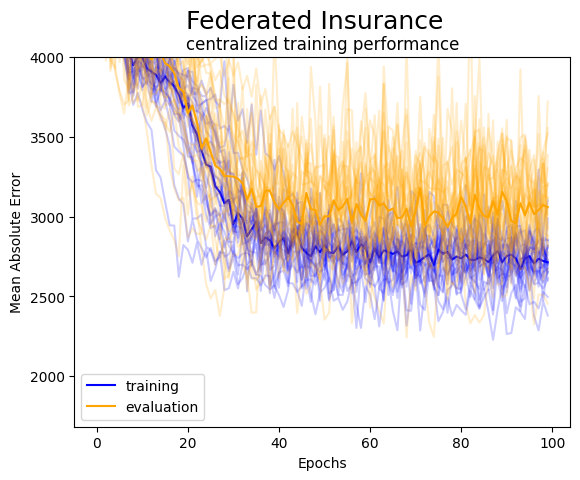

In [33]:
# plot train result (MAE)
# =======================
y1 = np.array([hist.history["mae"] for hist in results_ctr]).transpose()
y2 = np.array([hist.history["val_mae"] for hist in results_ctr]).transpose()

plt.plot(y1, color = 'blue', alpha = .2)
plt.plot(np.quantile(y1,.5, axis = 1), label = 'training', color = 'blue')
plt.plot(y2, color = 'orange', alpha = .2)
plt.plot(np.quantile(y2,.5, axis = 1), label = 'evaluation', color = 'orange')
plt.ylim([None, 4000])

plt.xlabel("Epochs")
plt.ylabel("Mean Absolute Error")
plt.suptitle('Federated Insurance', fontsize = 18)
plt.title('centralized training performance')
plt.legend()
plt.savefig(experiment_path + 'results/training_performance_mae.png')
plt.show()


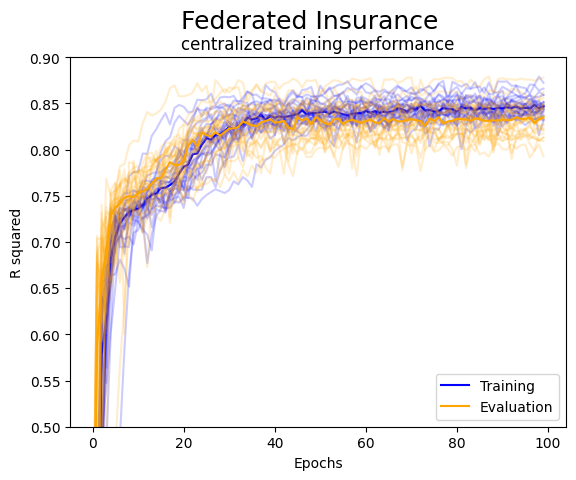

In [34]:
# plot train result (RSQ)
y1 = np.array([hist.history["r2_score"] for hist in results_ctr]).transpose()
y2 = np.array([hist.history["val_r2_score"] for hist in results_ctr]).transpose()

plt.plot(y1, color = 'blue', alpha = .2)
plt.plot(np.quantile(y1,.5, axis = 1), label = 'Training', color = 'blue')
plt.plot(y2, color = 'orange', alpha = .2)
plt.plot(np.quantile(y2,.5, axis = 1), label = 'Evaluation', color = 'orange')
plt.ylim([0.5, 0.9])
plt.xlabel("Epochs")
plt.ylabel("R squared")
plt.suptitle('Federated Insurance', fontsize = 18)
plt.title('centralized training performance')
plt.legend()
plt.savefig(experiment_path + 'results/training_performance_rsq.png')
plt.show()



### CTR Test
---

In [35]:
# compute test
# ============
results_test_ctr = []

i = 0
for train, test in tqdm.tqdm(list(evaluation.split(df, df.region))):
    data_test = df.loc[test]
    
    X_test, y_test = data_test[features], data_test[target]
    
    
    model = results_ctr[i].model
    i += 1
    perf_test  = model.evaluate(X_test, y_test, verbose = 0)
    perf_test = dict(zip(model.metrics_names, perf_test))
    results_test_ctr.append(perf_test)

100%|██████████| 25/25 [00:09<00:00,  2.70it/s]


In [36]:
# show test results
# =================
table2 = pd.DataFrame(results_test_ctr)
table2 = table2.set_axis(['test_'+ col for col in table2.columns], axis = 1)


table2.describe()[1:].to_csv(experiment_path + "results/performance_test_overview.csv", sep = ";")

table_all_ctr = pd.concat([table, table2], axis = 1)
table_all_ctr.describe()[1:].to_csv(experiment_path + "results/performance_overview.csv", sep = ";")
table_all_ctr.to_csv(experiment_path + "results/performance.csv", sep = ";")
table_all_ctr.describe()[1:].transpose().round(2)

,mean,std,min,25%,50%,75%,max
loss,21636685.76,1173220.87,18076764.00,21479838.00,21756194.00,22209778.00,23556022.00
mae,2730.71,145.73,2378.65,2655.45,2713.00,2814.41,3101.27
mean_squared_error,21636685.68,1173220.86,18076764.00,21479838.00,21756194.00,22209778.00,23556022.00
r2_score,0.85,0.01,0.83,0.84,0.85,0.85,0.87
val_loss,25541948.16,3123813.95,17238680.00,23899800.00,26055082.00,27373388.00,30845702.00
val_mae,3057.36,294.35,2453.87,2865.97,3059.46,3208.30,3720.82
val_mean_squared_error,25541948.08,3123813.85,17238680.00,23899800.00,26055082.00,27373388.00,30845700.00
val_r2_score,0.83,0.02,0.79,0.82,0.83,0.85,0.88
test_loss,23944278.08,3896210.95,19051910.00,21171816.00,22763138.00,26182238.00,32744460.00
test_mae,2921.51,277.92,2415.64,2716.87,2938.53,3086.32,3485.93


## Comparison
---

In [37]:
tab = pd.concat(
    [
    table_all_fed.loc[:,table_all_fed.columns.str.contains("mean|loss|mae|score")].describe(percentiles = []).assign(type = "federated")[1:3].rename(
        columns = {'mean_absolute_error': 'mae',
                   
                   'val_mean_absolute_error': 'val_mae',
                   
                   'test_mean_absolute_error': 'test_mae'
                   }
    ).transpose(),
    table_all_ctr.describe(percentiles = []).assign(type = "centralized")[1:3].transpose()
    ],
    axis = 1)


tab.loc[['type','loss', 'mae', 'mean_squared_error', 'r2_score', 
         'val_loss', 'val_mae', 'val_mean_squared_error', 'val_r2_score','test_loss',
         'test_mae', 'test_mean_squared_error', 'test_r2_score'
       ]]

,mean,std,mean,std
type,federated,federated,centralized,centralized
loss,21636685.76,1173220.870153,21636685.76,1173220.870153
mae,2730.710947,145.73357,2730.710947,145.73357
mean_squared_error,21636685.68,1173220.861078,21636685.68,1173220.861078
r2_score,0.846645,0.009879,0.846645,0.009879
val_loss,25541948.16,3123813.948647,25541948.16,3123813.948647
val_mae,3057.358682,294.348089,3057.358682,294.348089
val_mean_squared_error,25541948.08,3123813.850493,25541948.08,3123813.850493
val_r2_score,0.834513,0.018815,0.834513,0.018815
test_loss,26827767.12,3641358.535451,23944278.08,3896210.949815
